# Spherical landscape analysis for [Li, Na]CB11H12 and [Li, Na]B11H14

Instead of just sending a report with a ton of landscapes, I thought it better to set up a jupyter lab notebook that would allow the user to simply compare landscapes by selecting them. The idea was to then host this notebook on a server, but I wasn't able to make this work yet. If you're comfortable using jupyter lab, setting up the proper environment should be easy enough. I'll try an set up an installer later.

In [1]:
# Notebook header

import os, json

import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

from ipywidgets import interact, fixed
from monty.json import MontyDecoder, MontyEncoder

import matplotlib.pyplot as plt

# Taken from cage.cli.commands.analyze
def plot_landscape(landscape_data, reference_energy=None, energy_range=None,
                   contour_levels=0.1, set_contour_levels_manually=False):
    """
    Plot a landscape based on the data provided.

    Args:
        landscape_data:
        reference_energy:
        energy_range:
        contour_levels:
        set_contour_levels_manually:

    Returns:

    """
    landscape_type = landscape_data["type"]
    energy = landscape_data["energy"].copy()
    x_coords = landscape_data["x_coords"].copy()
    y_coords = landscape_data["y_coords"].copy()

    # Compare the energies versus an reference energy if provided
    if reference_energy is None:
        energy -= np.nanmin(energy)
    else:
        energy -= reference_energy

    # If no energy range is specified by the user, take (min, max)
    if energy_range is None:
        if reference_energy is None:
            energy_range = (np.nanmin(energy), np.nanmax(energy))
        else:
            energy_range = (np.nanmin(energy), 0)

    contour_levels = np.mgrid[energy_range[0]:energy_range[1]:contour_levels]

    # Plot the landscape
    plt.figure()
    plt.pcolormesh(x_coords, y_coords, energy, vmin=energy_range[0],
                   vmax=energy_range[1], cmap='viridis')
    cbar = plt.colorbar()
    cbar.set_label('Energy (eV)', size='x-large')
    cs = plt.contour(x_coords, y_coords, energy, colors='black',
                     levels=contour_levels, linewidths=0.6, linestyles='solid')

    if landscape_type == "sphere":
        plt.xlabel('$\\phi$', size='x-large', fontname='Georgia')
        plt.ylabel('$\\theta$', size='x-large', fontname='Georgia')
        plt.xticks(size="x-large")
        plt.yticks(size="x-large")
    else:
        raise NotImplementedError

    if set_contour_levels_manually:
        plt.clabel(cs, fontsize=10, inline_spacing=25, fmt='%1.1f',
                   manual=True)
    elif set_contour_levels_manually is None:
        pass
    else:
        plt.clabel(cs, fontsize=10, inline_spacing=25, fmt='%1.1f')

    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

    plt.show()

## Extracting the data from the landscape.json files

We used the following code to load the data from the output into a dictionary:

```Python
from cage.cli.commands.analyze import sphere_analysis, plot_landscape
from pymatgen.io.nwchem import NwOutput

data = dict()

# Data definers
anions = ["b11h14", "cb11h12"]
cations = ["Li", "Na"]
radii = [3.5, 4.0, 5.0, 6.0]

for anion in anions:
    
    data[anion] = dict()
    
    for cation in cations:
        
        data[anion][cation] = dict()
        
        molecule_dir = os.path.join("data", anion, cation)
        
        # Reference energy determination
        reference_energies = []

        for dir in os.listdir(molecule_dir):
            if dir.startswith("reference_"):
                reference_energies.append(NwOutput(
                    os.path.join(molecule_dir, dir, "radius=8.00", "result.out")
                ).data[0]["energies"][-1])

        # Take the smallest value for now
        data[anion][cation]["reference_energy"] = np.min(reference_energies)
        
        for radius in radii:
            
            sphere_dir = os.path.join(molecule_dir, "sphere_" + str(radius))
            if os.path.exists(sphere_dir):
                data[anion][cation]["sphere_R" + str(radius)] = sphere_analysis(sphere_dir, cation)

```

However, I've just added this code as Markdown, because uploading all the date to github is a bad idea. Instead, I wrote the data to a json file using the following code:

```Python
with open("all_data.json", "w") as file:
    json.dump(json.dumps(data, cls=MontyEncoder), file)
```

Which is also not executable in this notebook. However, below we load the data from the json file into a dictionary from a link to my Dropbox:

In [2]:
# Data definers
anions = ["b11h14", "cb11h12"]
cations = ["Li", "Na"]
radii = [3.5, 4.0, 5.0, 6.0]

url = "https://www.dropbox.com/s/imuuimclhu2gvoq/all_data.json?dl=1"
import urllib.request
u = urllib.request.urlopen(url)
data = u.read()
u.close()

loaded_data = json.loads(json.loads(data.decode("utf-8")), cls=MontyDecoder)

In [3]:
def plot_multiple_landscape_data(data, anion, cation, radius):
    try:
        plot_landscape(data[anion][cation]["sphere_R" + str(radius)],
                       reference_energy=data[anion][cation]["reference_energy"],
                       set_contour_levels_manually=None)
    except KeyError:
        print("This landscape has not been calculated yet.")

def interactive_lands_plot(data):
    interact(plot_multiple_landscape_data, data=fixed(data), anion=anions, cation=cations, radius=radii)

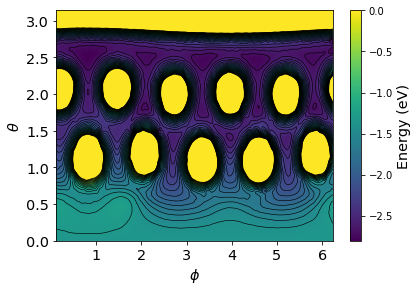

In [6]:
%matplotlib widget
%matplotlib inline
interactive_lands_plot(loaded_data)

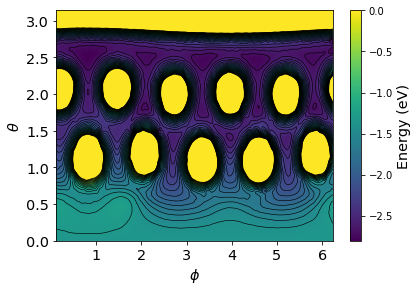

In [7]:
%matplotlib widget
%matplotlib inline
interactive_lands_plot(loaded_data)

If you've been able to set up the python environment correctly, you will see two identical landscapes above, as well as several drop down menu's from which you can choose the anion, cation and radius.

## Actual code to load the data from the output files

This is just here because I used this to load the data and write it to the json file in my Dropbox. Unless you have access to the data and have installed the cage package, it won't do you much good. :)

In [6]:
from cage.cli.commands.analyze import sphere_analysis, plot_landscape
from pymatgen.io.nwchem import NwOutput

data = dict()

# Data definers
anions = ["b11h14", "cb11h12"]
cations = ["Li", "Na"]
radii = [3.5, 4.0, 5.0, 6.0]

for anion in anions:
    
    data[anion] = dict()
    
    for cation in cations:
        
        data[anion][cation] = dict()
        
        molecule_dir = os.path.join("data", anion, cation)
        
        # Reference energy determination
        reference_energies = []

        for dir in os.listdir(molecule_dir):
            if dir.startswith("reference_"):
                reference_energies.append(NwOutput(
                    os.path.join(molecule_dir, dir, "radius=8.00", "result.out")
                ).data[0]["energies"][-1])

        # Take the smallest value for now
        data[anion][cation]["reference_energy"] = np.min(reference_energies)
        
        for radius in radii:
            
            sphere_dir = os.path.join(molecule_dir, "sphere_" + str(radius))
            if os.path.exists(sphere_dir):
                data[anion][cation]["sphere_R" + str(radius)] = sphere_analysis(sphere_dir, cation)
                sphere_plot = plot_landscape()

FileNotFoundError: [Errno 2] No such file or directory: 'data/b11h14/Li'

In [40]:
with open("b11h14_data.json", "w") as file:
    json.dump(json.dumps(data["b11h14"], cls=MontyEncoder), file)
with open("cb11h12_data.json", "w") as file:
    json.dump(json.dumps(data["cb11h12"], cls=MontyEncoder), file)
with open("all_data.json", "w") as file:
    json.dump(json.dumps(data, cls=MontyEncoder), file)

In [ ]:
# with open("b11h14_data.json", "r") as file:
#     b11h14_data = json.loads(json.load(file), cls=MontyDecoder)
# with open("cb11h12_data.json", "r") as file:
#     cb11h12_data = json.loads(json.load(file), cls=MontyDecoder)
    
# loaded_data = dict(); loaded_data["b11h14"] = b11h14_data; loaded_data["cb11h12"] = cb11h12_data